In [1]:
from pathlib import Path
import glob
import exiftool
import suncalc
import soundfile as sf
import re

In [2]:
import numpy as np
import pandas as pd
from celluloid import Camera
import dask.dataframe as dd

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

In [5]:
SEATTLE_LATITUDE = 47.655181
SEATTLE_LONGITUDE = -122.293123

In [6]:
site_locs = {'E18 Bridge':[180, 620],
            'Carp Pond':[600, 1160],
            'Bat Box':[550, 900],
            'Central Pond':[1140, 1060],
            'Foliage':[1600, 900],
            'Telephone Field':[1450, 220]}

In [7]:
nightly = pd.DataFrame()
LFnightly = pd.DataFrame()
HFnightly = pd.DataFrame()

In [8]:
sites = ["Telephone Field", 'Bat Box', 'Carp Pond', 'Foliage', 'Central Pond', 'E18 Bridge']
for site in sites:
    cfg = dict()
    cfg["site"] = site
    cfg["recording_start"] = '03:00'
    cfg["recording_end"] = '13:00'
    cfg['resample_tag'] = "10min"
    cfg['show_PST'] = False
    cfg['selection_of_dates'] = 'recover-20240820'

    new_df = dd.read_csv(f"../output_dir/{cfg['selection_of_dates']}/{cfg['site']}/activity__*.csv", assume_missing=True).compute()
    new_df["date_and_time_UTC"] = pd.to_datetime(new_df["date_and_time_UTC"], format="%Y-%m-%d %H:%M:%S%z")

    resampled_df = new_df.resample(cfg["resample_tag"], on="date_and_time_UTC").sum().between_time(cfg['recording_start'], cfg['recording_end'], inclusive='left')

    # activity_datetimes = pd.to_datetime(resampled_df.index.values)
    # raw_dates = activity_datetimes.date
    # raw_times = activity_datetimes.strftime("%H:%M")
    # data = list(zip(raw_dates, raw_times, resampled_df[f'num_of_detections']))
    # activity = pd.DataFrame(data, columns=["Date (UTC)", "Time (UTC)", f'num_of_detections'])
    # batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg, '', save=False)
    nightly[site] = resampled_df['LFnum_of_detections'].replace(1/3, 0)
    LFnightly[site] = resampled_df['LFnum_of_detections'].replace(1/3, 0)
    HFnightly[site] = resampled_df['HFnum_of_detections'].replace(1/3, 0)

LFnightly.index = ((LFnightly.index).tz_convert(tz='US/Pacific'))
HFnightly.index = ((HFnightly.index).tz_convert(tz='US/Pacific'))
nightly.index = ((nightly.index).tz_convert(tz='US/Pacific'))

In [9]:
resampled_df

,num_of_detections,LFnum_of_detections,HFnum_of_detections
date_and_time_UTC,,,
2024-08-13 03:00:00+00:00,0.333333,0.333333,0.333333
2024-08-13 03:10:00+00:00,0.333333,0.333333,0.333333
2024-08-13 03:20:00+00:00,0.333333,0.333333,0.333333
2024-08-13 03:30:00+00:00,0.333333,0.333333,0.333333
2024-08-13 03:40:00+00:00,0.333333,0.333333,0.333333
...,...,...,...
2024-08-20 12:10:00+00:00,0.333333,0.333333,0.333333
2024-08-20 12:20:00+00:00,0.333333,0.333333,0.333333
2024-08-20 12:30:00+00:00,10.000000,0.333333,10.000000


In [10]:
nightly

,Telephone Field,Bat Box,Carp Pond,Foliage,Central Pond,E18 Bridge
date_and_time_UTC,,,,,,
2024-08-12 20:00:00-07:00,0.0,0.0,0.0,2.0,2.0,0.0
2024-08-12 20:10:00-07:00,0.0,0.0,0.0,0.0,4.0,0.0
2024-08-12 20:20:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-12 20:30:00-07:00,0.0,0.0,0.0,2.0,0.0,0.0
2024-08-12 20:40:00-07:00,0.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...
2024-08-20 05:10:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-20 05:20:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-20 05:30:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0


20240812_night_activity


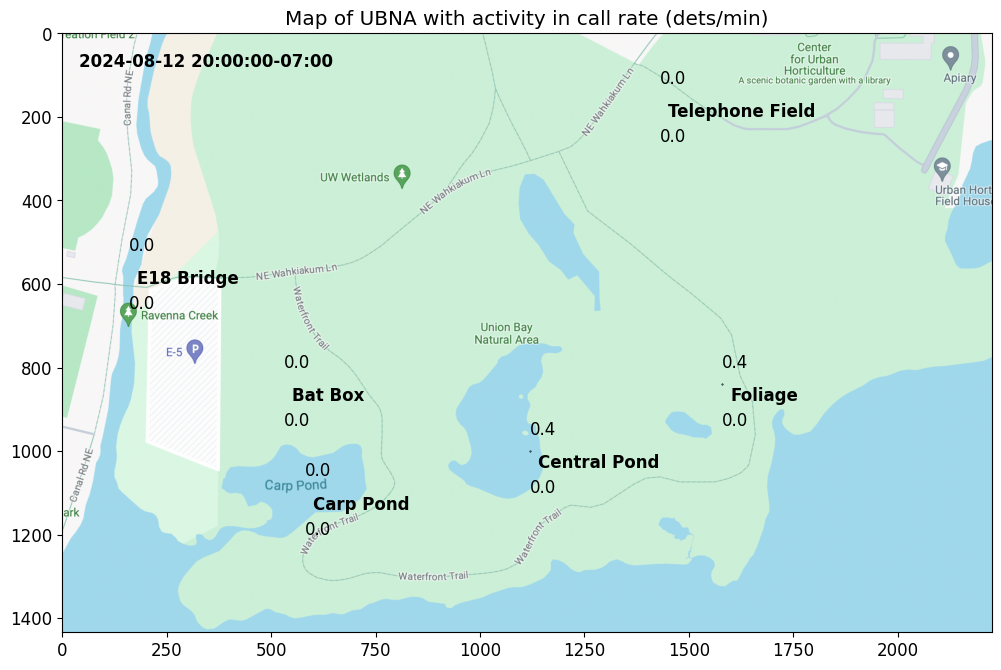

MovieWriter PillowWriter unavailable; using Pillow instead.


20240813_night_activity


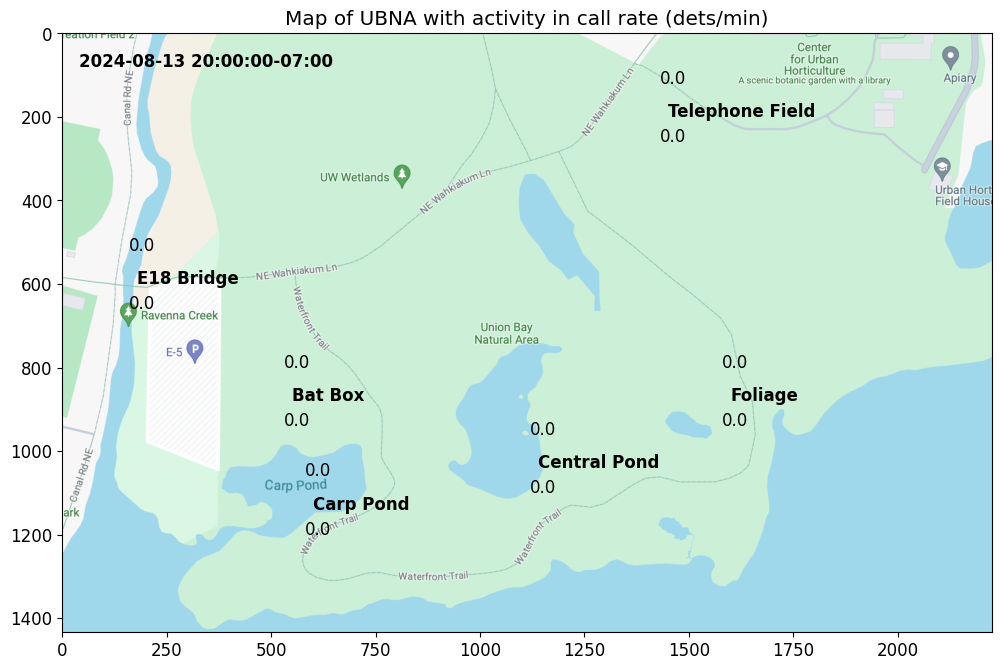

MovieWriter PillowWriter unavailable; using Pillow instead.


20240814_night_activity


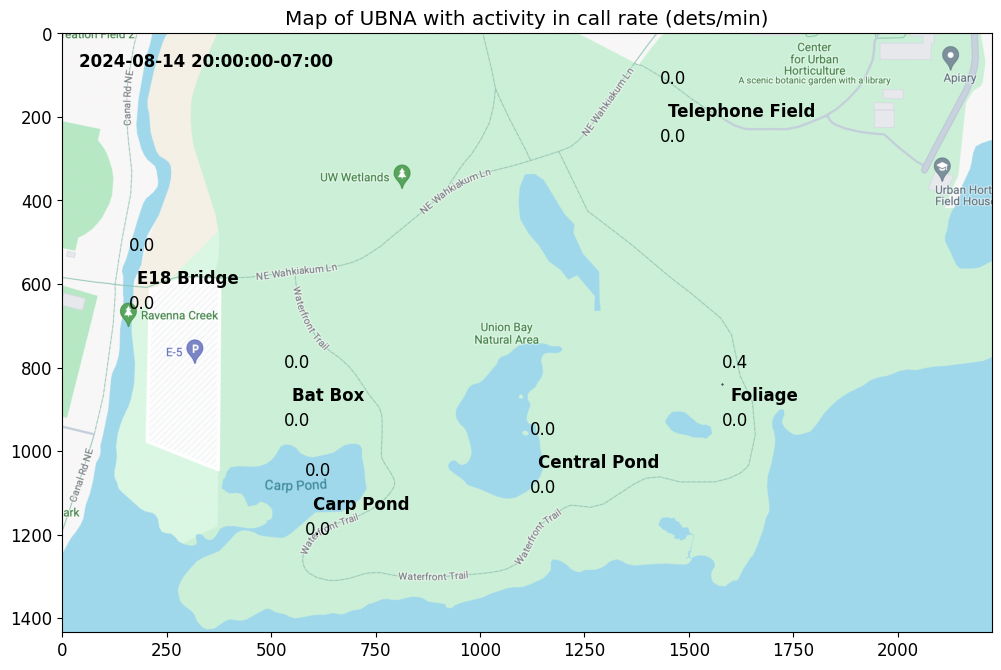

MovieWriter PillowWriter unavailable; using Pillow instead.


20240815_night_activity


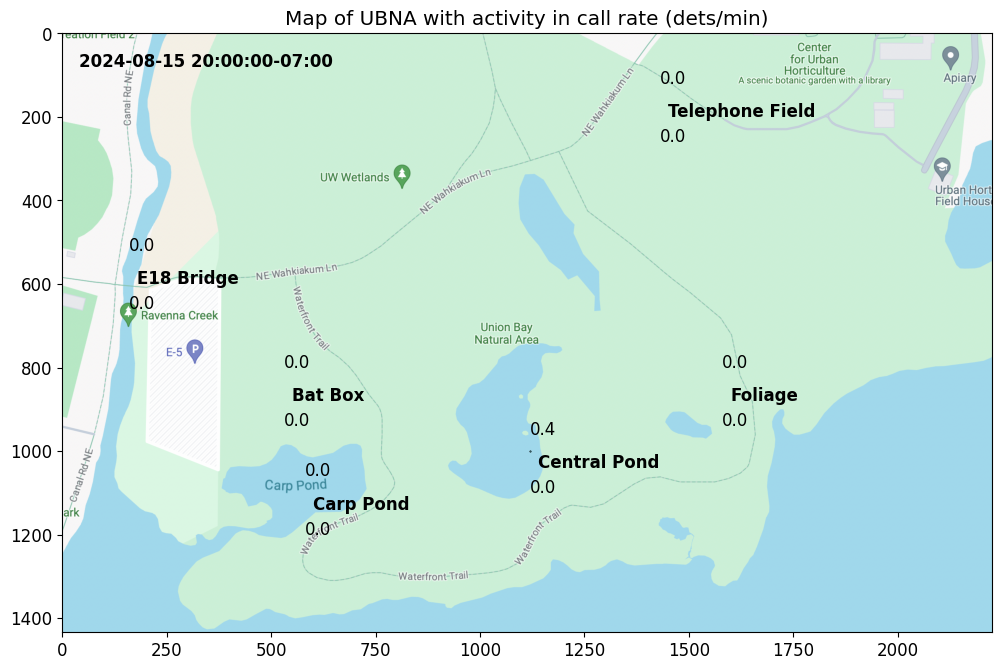

MovieWriter PillowWriter unavailable; using Pillow instead.


20240816_night_activity


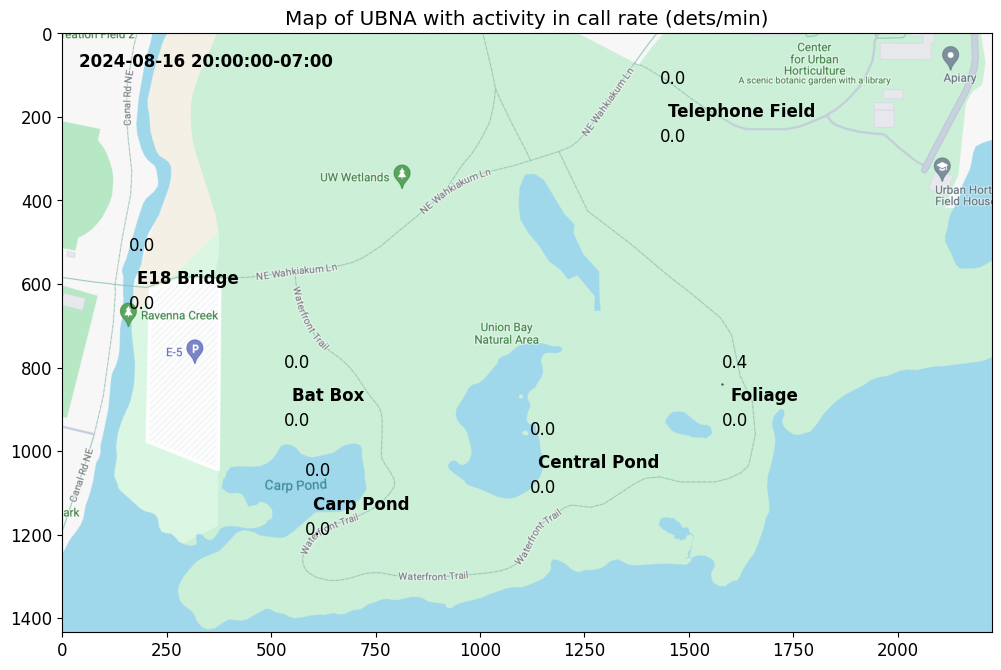

MovieWriter PillowWriter unavailable; using Pillow instead.


20240817_night_activity


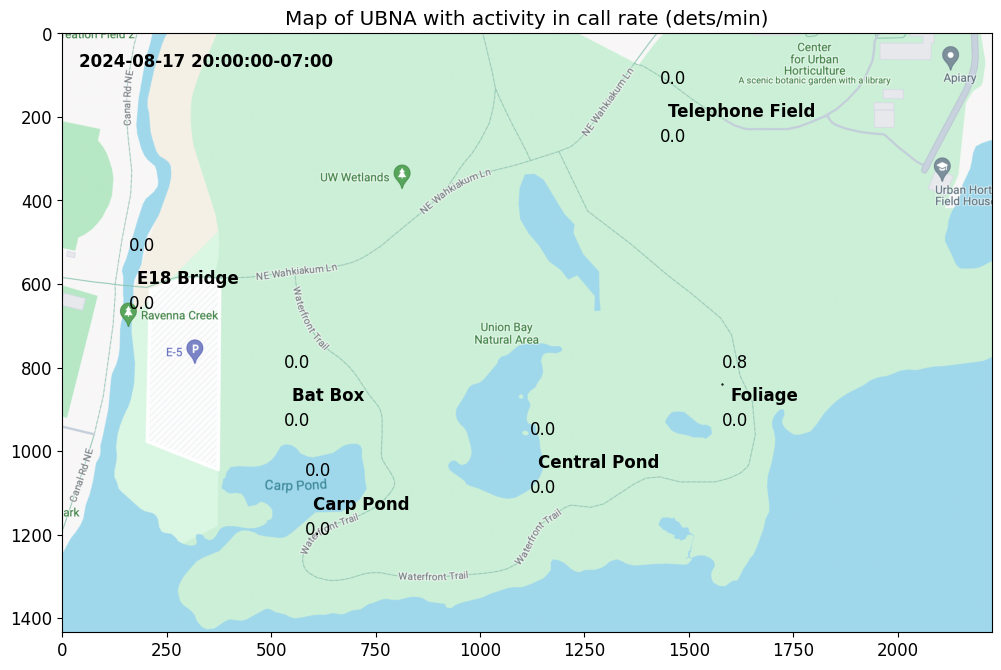

MovieWriter PillowWriter unavailable; using Pillow instead.


20240818_night_activity


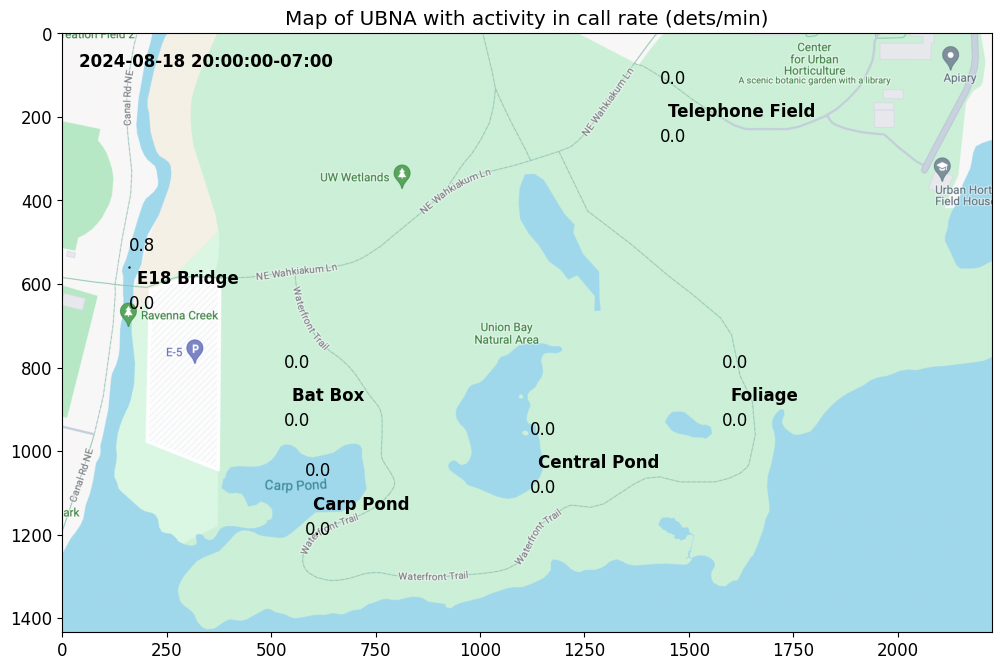

MovieWriter PillowWriter unavailable; using Pillow instead.


20240819_night_activity


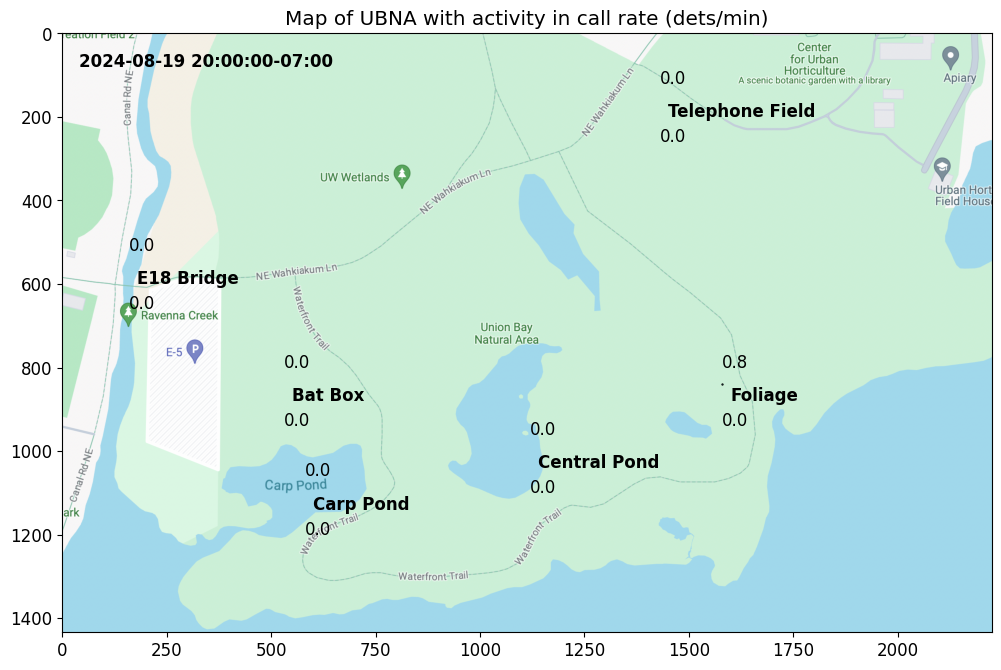

MovieWriter PillowWriter unavailable; using Pillow instead.


In [11]:
while len(nightly)>0:
    night = nightly.loc[nightly.index[0]:nightly.index[0]+pd.Timedelta(hours=23, minutes=50)]
    LFnight = LFnightly.loc[LFnightly.index[0]:LFnightly.index[0]+pd.Timedelta(hours=23, minutes=50)]
    HFnight = HFnightly.loc[HFnightly.index[0]:HFnightly.index[0]+pd.Timedelta(hours=23, minutes=50)]
    plot_title = f'{night.index[0].strftime("%Y%m%d")}_night_activity'
    print(plot_title)

    # create figure object
    fig = plt.figure(figsize=(12, 12))
    plt.rcParams.update({'font.size':12})
    # load axis box
    ax = plt.axes()

    camera = Camera(fig)

    for i in range(len(night)):
        img = plt.imread("../../Desktop/UBNA.jpg")
        ax.set_title('Map of UBNA with activity in call rate (dets/min)')
        ax.imshow(img)
        for site in sites:
            if not(np.isnan(LFnight.iloc[i][site])):
                ax.scatter(x=site_locs[site][0]-20,y=site_locs[site][-1]-60,s=LFnight.iloc[i][site]/10,facecolor='cyan', edgecolor='k')
                ax.text(x=site_locs[site][0],y=site_locs[site][-1]-20,s=site,fontweight='bold')
                ax.text(x=site_locs[site][0]-20,y=site_locs[site][-1]-100,s=f'{((LFnight.iloc[i][site]))/5}')
            else:
                ax.scatter(x=site_locs[site][0]-20,y=site_locs[site][-1]-60,s=10,facecolor='red', edgecolor='k')
                ax.text(x=site_locs[site][0],y=site_locs[site][-1]-20,s=site,fontweight='bold')
                ax.text(x=site_locs[site][0]-20,y=site_locs[site][-1]-100,s=f'no dets')

            if not(np.isnan(HFnight.iloc[i][site])):
                ax.scatter(x=site_locs[site][0]-20,y=site_locs[site][-1]+10,s=HFnight.iloc[i][site]/10,facecolor='orange', edgecolor='k')
                ax.text(x=site_locs[site][0]-20,y=site_locs[site][-1]+40,s=f'{((HFnight.iloc[i][site]))/5}')
            else:
                ax.scatter(x=site_locs[site][0]-20,y=site_locs[site][-1]+10,s=10,facecolor='red', edgecolor='k')
                ax.text(x=site_locs[site][0]-20,y=site_locs[site][-1]+40,s=f'no dets')
        
        ax.text(x=40,y=80,s=HFnight.iloc[i].name,fontweight='bold')

        plt.pause(0.1)
        camera.snap()
        plt.show()

    animation = camera.animate()
    animation.save(f'{plot_title}.gif', writer='PillowWriter', fps=2)
    nightly = nightly.drop(night.index)
    HFnightly = HFnightly.drop(HFnight.index)
    LFnightly = LFnightly.drop(LFnight.index)